In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Load & Prepare Data

In [7]:
df = pd.read_csv("MIMIC_IV_Trasncript.csv")

# keep only numeric vital signs
df = df.select_dtypes(include=np.number)

# handle missing values (ICU-safe)
df = df.ffill().bfill()

df.head()


C:\Users\Rahul Tej\AppData\Local\Temp\ipykernel_1840\916626151.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("MIMIC_IV_Trasncript.csv")


,subject_id,hadm_id,anchor_age,dose_val_rx,drg_severity,drg_mortality
0,10000032,22595853,52,0.0,2.0,2.0
1,10000032,22595853,52,0.0,2.0,2.0
2,10000032,22595853,52,0.0,2.0,2.0
3,10000032,22595853,52,0.0,2.0,2.0
4,10000032,22595853,52,0.0,2.0,2.0


## Normalize (MANDATORY for LSTM)

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_data.shape


(232158, 6)

## Create Multivariate Time-Series Sequences

In [9]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 24   # e.g., last 24 readings → next reading

X, y = create_sequences(scaled_data, TIME_STEPS)

X.shape, y.shape


((232134, 24, 6), (232134, 6))

## Train-Test Split (Time-Aware)

In [10]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Build Advanced LSTM Model

In [11]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    
    LSTM(64),
    Dropout(0.3),
    
    Dense(y_train.shape[1])  # multivariate output
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


C:\Users\Rahul Tej\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,918 (464.52 KB)

 Trainable params: 118,918 (464.52 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/2
5223/5223 ━━━━━━━━━━━━━━━━━━━━ 309s 58ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 2/2
5223/5223 ━━━━━━━━━━━━━━━━━━━━ 221s 42ms/step - loss: 0.0019 - val_loss: 0.0025


## Forecast Vital Signs

In [13]:
predictions = model.predict(X_test)

# inverse scale
y_test_inv = scaler.inverse_transform(y_test)
pred_inv = scaler.inverse_transform(predictions)


1451/1451 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step


## Model Accuracy (Medical-Friendly Metrics)

In [14]:
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
mae = mean_absolute_error(y_test_inv, pred_inv)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 66245.49851876743
MAE: 26767.338272024517


## Visualize Trend Forecast

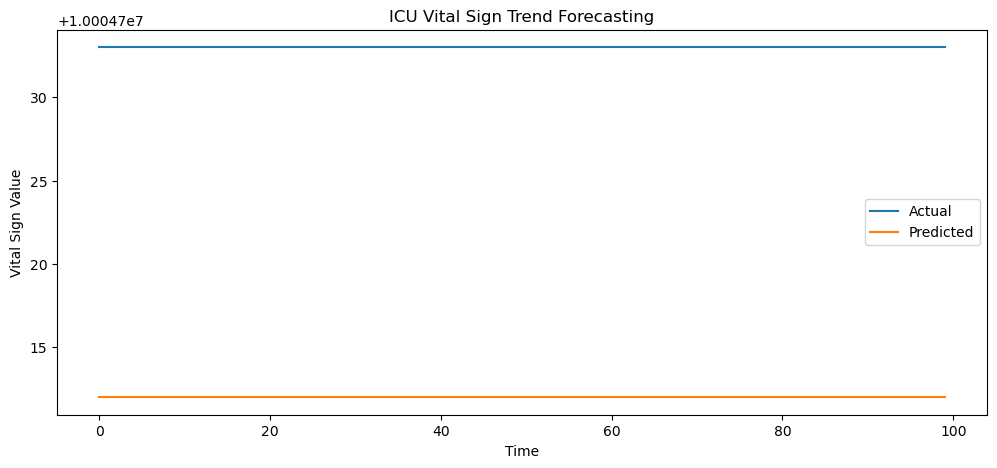

In [15]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:100, 0], label="Actual")
plt.plot(pred_inv[:100, 0], label="Predicted")
plt.title("ICU Vital Sign Trend Forecasting")
plt.xlabel("Time")
plt.ylabel("Vital Sign Value")
plt.legend()
plt.show()
